In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import math
import datetime

import plotly.express as px

import seaborn as sns
sns.set_style('whitegrid')

import itertools
from itertools import cycle
#plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm as tqdm
import statsmodels.api as sm




In [3]:
df_price = pd.read_csv(r'data\item_prices.csv')
df_sales = pd.read_csv(r'data\item_sales.csv')
df_events = pd.read_csv(r'data\daily_calendar_with_events.csv')

df_price.head()


,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858


In [4]:
df_sales.head()

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
print('Tamanho:',  df_events.shape)
print(df_events.head(338))

Tamanho: (1913, 5)
           date    weekday  weekday_int      d    event
0    2011-01-29   Saturday            1    d_1      NaN
1    2011-01-30     Sunday            2    d_2      NaN
2    2011-01-31     Monday            3    d_3      NaN
3    2011-02-01    Tuesday            4    d_4      NaN
4    2011-02-02  Wednesday            5    d_5      NaN
..          ...        ...          ...    ...      ...
333  2011-12-28  Wednesday            5  d_334      NaN
334  2011-12-29   Thursday            6  d_335      NaN
335  2011-12-30     Friday            7  d_336      NaN
336  2011-12-31   Saturday            1  d_337      NaN
337  2012-01-01     Sunday            2  d_338  NewYear

[338 rows x 5 columns]


In [6]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [7]:
df_events.groupby(['event'])['weekday_int'].count()

event
Easter            5
NewYear           5
Ramadan starts    5
SuperBowl         6
Thanksgiving      5
Name: weekday_int, dtype: int64

In [8]:
calendar = df_events.groupby(['event'])['weekday_int'].value_counts().reset_index(name='counts')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4380\1939104112.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'event', y='counts', data=calendar,


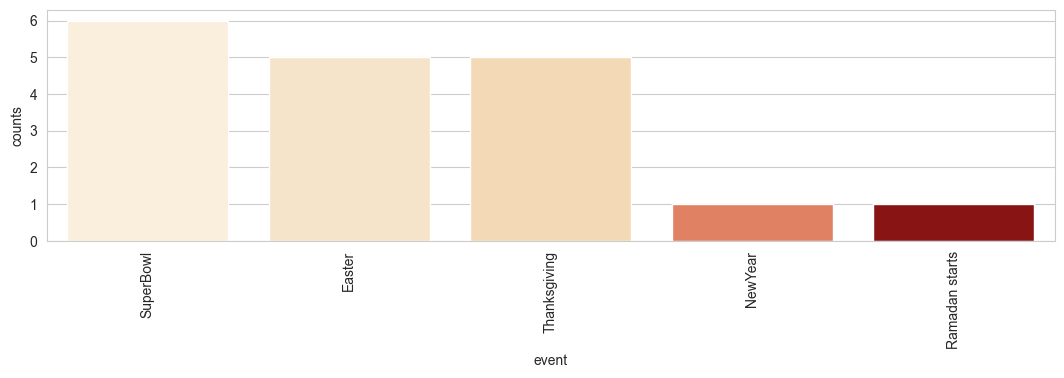

In [9]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'event', y='counts', data=calendar, 
            order = calendar.sort_values(['counts'], ascending=False).event, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

In [10]:
d_cols = [c for c in df_sales.columns if 'd_' in c]
df_sales['total_sales_all_days'] = df_sales[d_cols].sum(axis = 1)
df_sales['avg_sales_all_days'] = df_sales[d_cols].mean(axis = 1)
df_sales['median_sales_all_days'] = df_sales[d_cols].median(axis = 1)
df_sales.head()


,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_sales_all_days,avg_sales_all_days,median_sales_all_days
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,1,1,3,0,1,1,600,0.313643,0.0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,1,0,0,0,0,493,0.257710,0.0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,1,1,0,1,1,1,288,0.150549,0.0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,4,1,0,1,3,7,2,3288,1.718766,1.0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,1,1,2,2,2,4,1849,0.966545,1.0


In [11]:
train_sales_cal_df = df_sales.set_index('id')[d_cols].T.merge(df_events.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [12]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [13]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

Destaca-se que as vendas no dia de Natal são muito baixas

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

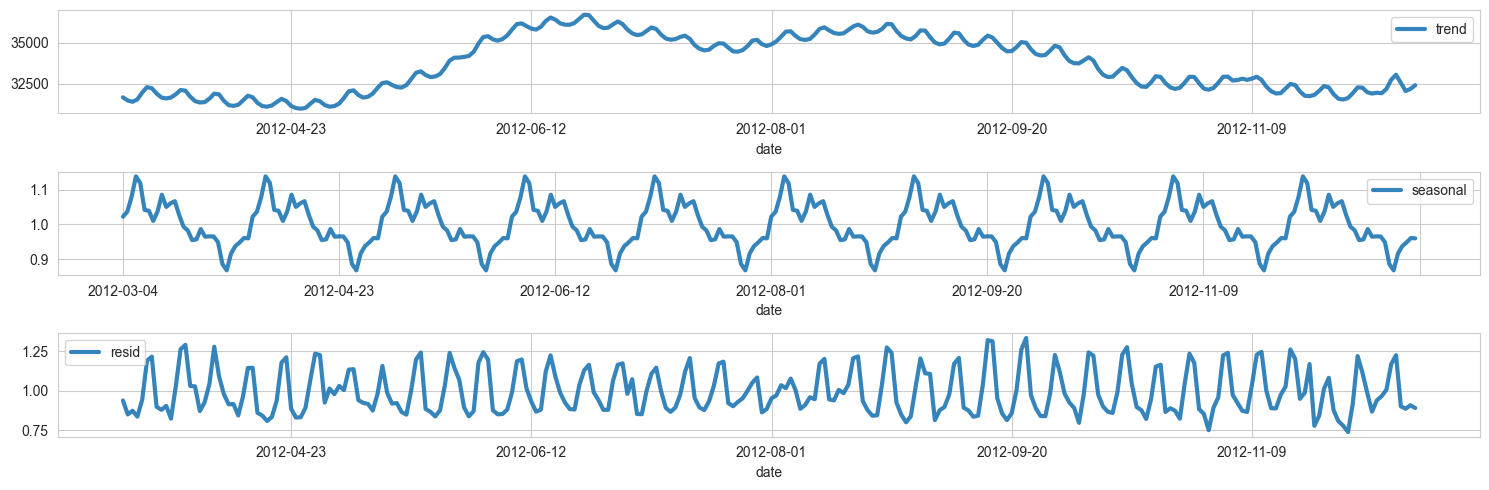

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

depois de observarmos a tendência, os padrões de sazonalidade e de resíduos, temos a seguinte informação recolhida:

- Definitivamente há sazonalidade em nosso conjunto de dados e, para observar seu padrão, pegamos um subconjunto de conjunto de dados
- Como os componentes sazonais e residuais estão alterando a linha de tendência em um valor que é “dependente” das mudanças nos componentes sazonais e residuais, temos um comportamento multiplicativo


In [16]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [17]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

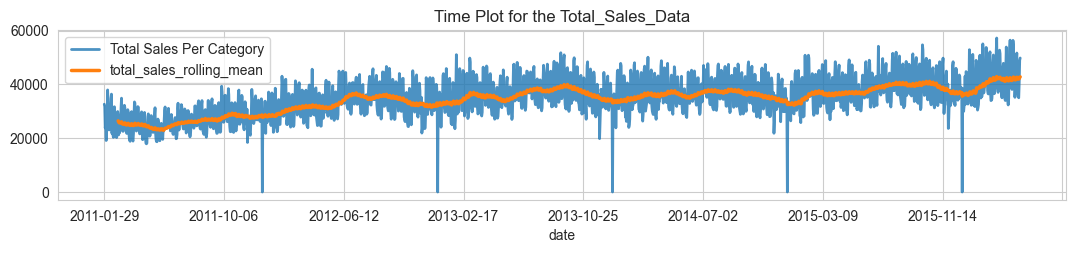

In [18]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

In [19]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = df_sales.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

,id,total_sales
0,SUPERMARKET_3_090_NYC_3,250502
1,SUPERMARKET_3_586_BOS_2,192835
2,SUPERMARKET_3_586_BOS_3,150122
3,SUPERMARKET_3_586_NYC_3,134386
4,SUPERMARKET_3_090_NYC_1,127203


In [20]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
BOS    1233196
NYC    1005717
PHI     470367
Name: total_sales, dtype: int64

Entre as categorias mais populares e dos 25 itens mais vendidos, os itens mais vendidos foram superior em Boston do que em Nova York ou na Philadelphia.

In [21]:
train_sales_cal_df = df_sales.set_index('id')[d_cols].T.merge(df_events.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df = train_sales_cal_df.apply(pd.to_numeric, errors='coerce')
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)



In [22]:
train_dataset = df_sales[d_cols[-100:-30]]
val_dataset = df_sales[d_cols[-30:]]

In [23]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [24]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

Naive Aproach

In [25]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [26]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

Moving average

In [27]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [28]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

Exponential smoothing

In [29]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Exponential smoothing")
fig.show()

ARIMA

In [31]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

  0%|          | 0/3 [00:00<?, ?it/s]

e:\001_Rodrigo\RotinasPython\Estudos\NDS\DCTP\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [32]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

In [33]:
#Verificação de Perdas

# Dados
error = [error_naive, error_avg, error_exponential, error_arima]
names = ["Naive approach", "Moving average", "Exponential smoothing", "ARIMA"]

# Criação do DataFrame
df = pd.DataFrame({
    "RMSE Loss": error,
    "Model": names
})

# Ordenar o DataFrame pelos valores de RMSE Loss
df = df.sort_values(by="RMSE Loss")

# Criação do gráfico de barras com Plotly Express
fig = px.bar(df, 
             x="Model", 
             y="RMSE Loss", 
             color="Model",
             title="RMSE Loss vs. Model",
             labels={"RMSE Loss": "RMSE Loss", "Model": "Model"},
             text="RMSE Loss",  # Adiciona rótulos com os valores de RMSE Loss
             color_discrete_sequence=px.colors.qualitative.Plotly  # Escolhe uma paleta de cores
            )

# Configurações adicionais para melhorar a aparência
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='RMSE Loss',
    xaxis_tickangle=-45,  # Inclina os rótulos do eixo x para melhorar a legibilidade
    title_font_size=20,
    xaxis_title_font_size=15,
    yaxis_title_font_size=15,
    legend_title_text='Model',
    legend_title_font_size=15,
    legend_font_size=12
)

# Exibe o gráfico
fig.show()


Os modelos com melhores resultados foram o Exponential Smoothing e Moving Avarage